# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "nShot_oracle.run2",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "x_transforms_source": [],
    "x_transforms_target": [],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "num_examples_per_domain_per_label_source": 1000,
    "num_examples_per_domain_per_label_target": 1000,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 1,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "n_shot": 4,
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.004484568
Average power, source: 2.6432685e-05


Average magnitude, target: 0.002903775
Average power, target: 1.06573525e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 348], examples_per_second: 652.9534, train_label_loss: 2.2371, 


epoch: 1, [batch: 35 / 348], examples_per_second: 3418.0573, train_label_loss: 1.2198, 


epoch: 1, [batch: 70 / 348], examples_per_second: 3440.0084, train_label_loss: 1.1001, 


epoch: 1, [batch: 105 / 348], examples_per_second: 3479.3306, train_label_loss: 1.1294, 


epoch: 1, [batch: 139 / 348], examples_per_second: 3480.2565, train_label_loss: 1.0967, 


epoch: 1, [batch: 174 / 348], examples_per_second: 3428.1594, train_label_loss: 1.2395, 


epoch: 1, [batch: 209 / 348], examples_per_second: 3481.0933, train_label_loss: 1.2359, 


epoch: 1, [batch: 243 / 348], examples_per_second: 3469.2816, train_label_loss: 0.9953, 


epoch: 1, [batch: 278 / 348], examples_per_second: 3431.8777, train_label_loss: 1.0852, 


epoch: 1, [batch: 313 / 348], examples_per_second: 3395.7409, train_label_loss: 1.2755, 


epoch: 1, source_val_acc_label: 0.4646, target_val_acc_label: 0.3880, source_val_label_loss: 1.6904, target_val_label_loss: 1.8317, 


New best


epoch: 2, [batch: 1 / 348], examples_per_second: 43.1501, train_label_loss: 1.8937, 


epoch: 2, [batch: 35 / 348], examples_per_second: 3478.1185, train_label_loss: 1.1021, 


epoch: 2, [batch: 70 / 348], examples_per_second: 3495.3782, train_label_loss: 1.3005, 


epoch: 2, [batch: 105 / 348], examples_per_second: 3515.5365, train_label_loss: 1.3377, 


epoch: 2, [batch: 139 / 348], examples_per_second: 3491.5281, train_label_loss: 1.2683, 


epoch: 2, [batch: 174 / 348], examples_per_second: 3489.8385, train_label_loss: 1.3983, 


epoch: 2, [batch: 209 / 348], examples_per_second: 3483.9693, train_label_loss: 1.3223, 


epoch: 2, [batch: 243 / 348], examples_per_second: 3479.1898, train_label_loss: 1.0587, 


epoch: 2, [batch: 278 / 348], examples_per_second: 3514.6843, train_label_loss: 1.3410, 


epoch: 2, [batch: 313 / 348], examples_per_second: 3490.6554, train_label_loss: 1.2099, 


epoch: 2, source_val_acc_label: 0.4838, target_val_acc_label: 0.3982, source_val_label_loss: 1.2360, target_val_label_loss: 1.6826, 


New best


epoch: 3, [batch: 1 / 348], examples_per_second: 43.4127, train_label_loss: 1.2999, 


epoch: 3, [batch: 35 / 348], examples_per_second: 3502.4302, train_label_loss: 1.0557, 


epoch: 3, [batch: 70 / 348], examples_per_second: 3491.5444, train_label_loss: 1.3673, 


epoch: 3, [batch: 105 / 348], examples_per_second: 3498.8676, train_label_loss: 1.2227, 


epoch: 3, [batch: 139 / 348], examples_per_second: 3493.1736, train_label_loss: 1.3540, 


epoch: 3, [batch: 174 / 348], examples_per_second: 3475.9263, train_label_loss: 1.3287, 


epoch: 3, [batch: 209 / 348], examples_per_second: 3483.0067, train_label_loss: 1.4001, 


epoch: 3, [batch: 243 / 348], examples_per_second: 3502.6964, train_label_loss: 1.2196, 


epoch: 3, [batch: 278 / 348], examples_per_second: 3492.5663, train_label_loss: 1.2076, 


epoch: 3, [batch: 313 / 348], examples_per_second: 3499.0657, train_label_loss: 1.1118, 


epoch: 3, source_val_acc_label: 0.4913, target_val_acc_label: 0.4121, source_val_label_loss: 1.2530, target_val_label_loss: 1.9134, 


epoch: 4, [batch: 1 / 348], examples_per_second: 41.2723, train_label_loss: 1.0523, 


epoch: 4, [batch: 35 / 348], examples_per_second: 3283.3999, train_label_loss: 1.0199, 


epoch: 4, [batch: 70 / 348], examples_per_second: 3259.5903, train_label_loss: 1.1810, 


epoch: 4, [batch: 105 / 348], examples_per_second: 3282.6833, train_label_loss: 1.2632, 


epoch: 4, [batch: 139 / 348], examples_per_second: 3313.3531, train_label_loss: 1.0581, 


epoch: 4, [batch: 174 / 348], examples_per_second: 3331.5118, train_label_loss: 1.0171, 


epoch: 4, [batch: 209 / 348], examples_per_second: 3202.2790, train_label_loss: 1.1989, 


epoch: 4, [batch: 243 / 348], examples_per_second: 3320.5900, train_label_loss: 1.4837, 


epoch: 4, [batch: 278 / 348], examples_per_second: 3215.2587, train_label_loss: 1.0095, 


epoch: 4, [batch: 313 / 348], examples_per_second: 3293.5349, train_label_loss: 1.2240, 


epoch: 4, source_val_acc_label: 0.4944, target_val_acc_label: 0.4106, source_val_label_loss: 1.2299, target_val_label_loss: 1.9563, 


epoch: 5, [batch: 1 / 348], examples_per_second: 41.2105, train_label_loss: 1.3958, 


epoch: 5, [batch: 35 / 348], examples_per_second: 3316.3726, train_label_loss: 1.2806, 


epoch: 5, [batch: 70 / 348], examples_per_second: 3369.4593, train_label_loss: 1.4835, 


epoch: 5, [batch: 105 / 348], examples_per_second: 3498.5306, train_label_loss: 1.4119, 


epoch: 5, [batch: 139 / 348], examples_per_second: 3456.5847, train_label_loss: 0.9924, 


epoch: 5, [batch: 174 / 348], examples_per_second: 3435.2464, train_label_loss: 1.1391, 


epoch: 5, [batch: 209 / 348], examples_per_second: 3470.4993, train_label_loss: 1.0309, 


epoch: 5, [batch: 243 / 348], examples_per_second: 3458.5888, train_label_loss: 1.1654, 


epoch: 5, [batch: 278 / 348], examples_per_second: 3461.7035, train_label_loss: 1.0712, 


epoch: 5, [batch: 313 / 348], examples_per_second: 3351.1131, train_label_loss: 1.0987, 


epoch: 5, source_val_acc_label: 0.5158, target_val_acc_label: 0.4199, source_val_label_loss: 1.1714, target_val_label_loss: 1.6811, 


New best


epoch: 6, [batch: 1 / 348], examples_per_second: 41.3779, train_label_loss: 1.0638, 


epoch: 6, [batch: 35 / 348], examples_per_second: 3482.7709, train_label_loss: 1.1000, 


epoch: 6, [batch: 70 / 348], examples_per_second: 3442.4167, train_label_loss: 1.0877, 


epoch: 6, [batch: 105 / 348], examples_per_second: 3468.7661, train_label_loss: 1.1626, 


epoch: 6, [batch: 139 / 348], examples_per_second: 3451.1587, train_label_loss: 1.0476, 


epoch: 6, [batch: 174 / 348], examples_per_second: 3466.7856, train_label_loss: 1.1786, 


epoch: 6, [batch: 209 / 348], examples_per_second: 3459.1892, train_label_loss: 1.0811, 


epoch: 6, [batch: 243 / 348], examples_per_second: 3452.4729, train_label_loss: 1.2501, 


epoch: 6, [batch: 278 / 348], examples_per_second: 3454.0083, train_label_loss: 1.0566, 


epoch: 6, [batch: 313 / 348], examples_per_second: 3480.3634, train_label_loss: 1.1136, 


epoch: 6, source_val_acc_label: 0.5102, target_val_acc_label: 0.4213, source_val_label_loss: 1.1675, target_val_label_loss: 1.6277, 


New best


epoch: 7, [batch: 1 / 348], examples_per_second: 42.9643, train_label_loss: 1.0577, 


epoch: 7, [batch: 35 / 348], examples_per_second: 3445.9544, train_label_loss: 1.1673, 


epoch: 7, [batch: 70 / 348], examples_per_second: 3479.8203, train_label_loss: 1.0384, 


epoch: 7, [batch: 105 / 348], examples_per_second: 3468.7371, train_label_loss: 1.1151, 


epoch: 7, [batch: 139 / 348], examples_per_second: 3489.2135, train_label_loss: 1.2917, 


epoch: 7, [batch: 174 / 348], examples_per_second: 3449.1754, train_label_loss: 1.8659, 


epoch: 7, [batch: 209 / 348], examples_per_second: 3407.2916, train_label_loss: 0.9244, 


epoch: 7, [batch: 243 / 348], examples_per_second: 3406.9474, train_label_loss: 1.1748, 


epoch: 7, [batch: 278 / 348], examples_per_second: 3384.2260, train_label_loss: 1.0966, 


epoch: 7, [batch: 313 / 348], examples_per_second: 3422.7882, train_label_loss: 1.0920, 


epoch: 7, source_val_acc_label: 0.5073, target_val_acc_label: 0.4270, source_val_label_loss: 1.1765, target_val_label_loss: 1.7049, 


epoch: 8, [batch: 1 / 348], examples_per_second: 43.7201, train_label_loss: 1.1743, 


epoch: 8, [batch: 35 / 348], examples_per_second: 3371.9185, train_label_loss: 1.0620, 


epoch: 8, [batch: 70 / 348], examples_per_second: 3445.2165, train_label_loss: 1.3055, 


epoch: 8, [batch: 105 / 348], examples_per_second: 3518.4997, train_label_loss: 1.2107, 


epoch: 8, [batch: 139 / 348], examples_per_second: 3408.8476, train_label_loss: 1.1536, 


epoch: 8, [batch: 174 / 348], examples_per_second: 3491.2979, train_label_loss: 1.2709, 


epoch: 8, [batch: 209 / 348], examples_per_second: 3471.7553, train_label_loss: 1.1209, 


epoch: 8, [batch: 243 / 348], examples_per_second: 3487.7788, train_label_loss: 1.0231, 


epoch: 8, [batch: 278 / 348], examples_per_second: 3473.4358, train_label_loss: 1.1305, 


epoch: 8, [batch: 313 / 348], examples_per_second: 3483.5172, train_label_loss: 1.0834, 


epoch: 8, source_val_acc_label: 0.5044, target_val_acc_label: 0.4214, source_val_label_loss: 1.1919, target_val_label_loss: 1.8040, 


epoch: 9, [batch: 1 / 348], examples_per_second: 43.9162, train_label_loss: 0.9583, 


epoch: 9, [batch: 35 / 348], examples_per_second: 3469.3281, train_label_loss: 1.0419, 


epoch: 9, [batch: 70 / 348], examples_per_second: 3476.6851, train_label_loss: 0.9565, 


epoch: 9, [batch: 105 / 348], examples_per_second: 3470.8395, train_label_loss: 1.0074, 


epoch: 9, [batch: 139 / 348], examples_per_second: 3459.4925, train_label_loss: 1.0522, 


epoch: 9, [batch: 174 / 348], examples_per_second: 3460.5500, train_label_loss: 0.9489, 


epoch: 9, [batch: 209 / 348], examples_per_second: 3466.7694, train_label_loss: 0.9452, 


epoch: 9, [batch: 243 / 348], examples_per_second: 3456.2968, train_label_loss: 1.0962, 


epoch: 9, [batch: 278 / 348], examples_per_second: 3482.6572, train_label_loss: 0.9128, 


epoch: 9, [batch: 313 / 348], examples_per_second: 3499.6791, train_label_loss: 1.0789, 


epoch: 9, source_val_acc_label: 0.6744, target_val_acc_label: 0.5312, source_val_label_loss: 0.8711, target_val_label_loss: 1.7490, 


epoch: 10, [batch: 1 / 348], examples_per_second: 43.8527, train_label_loss: 0.7974, 


epoch: 10, [batch: 35 / 348], examples_per_second: 3488.7316, train_label_loss: 0.8075, 


epoch: 10, [batch: 70 / 348], examples_per_second: 3447.3276, train_label_loss: 0.7830, 


epoch: 10, [batch: 105 / 348], examples_per_second: 3481.7624, train_label_loss: 0.4897, 


epoch: 10, [batch: 139 / 348], examples_per_second: 3486.3461, train_label_loss: 0.9156, 


epoch: 10, [batch: 174 / 348], examples_per_second: 3446.4635, train_label_loss: 0.5092, 


epoch: 10, [batch: 209 / 348], examples_per_second: 3495.4328, train_label_loss: 0.8611, 


epoch: 10, [batch: 243 / 348], examples_per_second: 3451.2179, train_label_loss: 0.8086, 


epoch: 10, [batch: 278 / 348], examples_per_second: 3465.9202, train_label_loss: 0.6521, 


epoch: 10, [batch: 313 / 348], examples_per_second: 3474.7316, train_label_loss: 0.7769, 


epoch: 10, source_val_acc_label: 0.7210, target_val_acc_label: 0.5893, source_val_label_loss: 0.7204, target_val_label_loss: 1.5221, 


New best


epoch: 11, [batch: 1 / 348], examples_per_second: 43.1902, train_label_loss: 0.7929, 


epoch: 11, [batch: 35 / 348], examples_per_second: 3466.8787, train_label_loss: 0.8506, 


epoch: 11, [batch: 70 / 348], examples_per_second: 3468.9711, train_label_loss: 0.7828, 


epoch: 11, [batch: 105 / 348], examples_per_second: 3483.0678, train_label_loss: 0.4643, 


epoch: 11, [batch: 139 / 348], examples_per_second: 3478.4976, train_label_loss: 0.8900, 


epoch: 11, [batch: 174 / 348], examples_per_second: 3482.5901, train_label_loss: 0.6876, 


epoch: 11, [batch: 209 / 348], examples_per_second: 3495.5152, train_label_loss: 0.4609, 


epoch: 11, [batch: 243 / 348], examples_per_second: 3481.1520, train_label_loss: 0.5598, 


epoch: 11, [batch: 278 / 348], examples_per_second: 3470.5156, train_label_loss: 0.3821, 


epoch: 11, [batch: 313 / 348], examples_per_second: 3479.3984, train_label_loss: 0.8940, 


epoch: 11, source_val_acc_label: 0.7325, target_val_acc_label: 0.5904, source_val_label_loss: 0.7066, target_val_label_loss: 1.3723, 


New best


epoch: 12, [batch: 1 / 348], examples_per_second: 43.2920, train_label_loss: 0.6031, 


epoch: 12, [batch: 35 / 348], examples_per_second: 3469.7959, train_label_loss: 0.4650, 


epoch: 12, [batch: 70 / 348], examples_per_second: 3498.8311, train_label_loss: 0.3561, 


epoch: 12, [batch: 105 / 348], examples_per_second: 3482.8164, train_label_loss: 0.7367, 


epoch: 12, [batch: 139 / 348], examples_per_second: 3513.3096, train_label_loss: 0.7105, 


epoch: 12, [batch: 174 / 348], examples_per_second: 3502.8637, train_label_loss: 0.4790, 


epoch: 12, [batch: 209 / 348], examples_per_second: 3469.3605, train_label_loss: 0.6073, 


epoch: 12, [batch: 243 / 348], examples_per_second: 3436.3818, train_label_loss: 0.7433, 


epoch: 12, [batch: 278 / 348], examples_per_second: 3474.3683, train_label_loss: 0.3615, 


epoch: 12, [batch: 313 / 348], examples_per_second: 3425.0450, train_label_loss: 0.1782, 


epoch: 12, source_val_acc_label: 0.7529, target_val_acc_label: 0.6098, source_val_label_loss: 0.6546, target_val_label_loss: 1.3610, 


New best


epoch: 13, [batch: 1 / 348], examples_per_second: 43.0891, train_label_loss: 0.5602, 


epoch: 13, [batch: 35 / 348], examples_per_second: 3479.9176, train_label_loss: 0.5473, 


epoch: 13, [batch: 70 / 348], examples_per_second: 3438.9172, train_label_loss: 0.5281, 


epoch: 13, [batch: 105 / 348], examples_per_second: 3477.4658, train_label_loss: 0.6437, 


epoch: 13, [batch: 139 / 348], examples_per_second: 3462.2257, train_label_loss: 0.4135, 


epoch: 13, [batch: 174 / 348], examples_per_second: 3468.0704, train_label_loss: 0.5415, 


epoch: 13, [batch: 209 / 348], examples_per_second: 3465.4361, train_label_loss: 0.7182, 


epoch: 13, [batch: 243 / 348], examples_per_second: 3501.8802, train_label_loss: 0.3428, 


epoch: 13, [batch: 278 / 348], examples_per_second: 3436.5675, train_label_loss: 0.4363, 


epoch: 13, [batch: 313 / 348], examples_per_second: 3474.8078, train_label_loss: 0.6372, 


epoch: 13, source_val_acc_label: 0.7700, target_val_acc_label: 0.6158, source_val_label_loss: 0.6137, target_val_label_loss: 1.2563, 


New best


epoch: 14, [batch: 1 / 348], examples_per_second: 43.2249, train_label_loss: 0.3364, 


epoch: 14, [batch: 35 / 348], examples_per_second: 3453.7228, train_label_loss: 0.7412, 


epoch: 14, [batch: 70 / 348], examples_per_second: 3476.0771, train_label_loss: 0.3057, 


epoch: 14, [batch: 105 / 348], examples_per_second: 3467.4458, train_label_loss: 0.4843, 


epoch: 14, [batch: 139 / 348], examples_per_second: 3484.4543, train_label_loss: 0.4525, 


epoch: 14, [batch: 174 / 348], examples_per_second: 3454.5950, train_label_loss: 0.4532, 


epoch: 14, [batch: 209 / 348], examples_per_second: 3464.6677, train_label_loss: 0.6223, 


epoch: 14, [batch: 243 / 348], examples_per_second: 3480.4777, train_label_loss: 0.6266, 


epoch: 14, [batch: 278 / 348], examples_per_second: 3469.2443, train_label_loss: 0.9386, 


epoch: 14, [batch: 313 / 348], examples_per_second: 3470.6805, train_label_loss: 0.2282, 


epoch: 14, source_val_acc_label: 0.7735, target_val_acc_label: 0.6186, source_val_label_loss: 0.6251, target_val_label_loss: 1.4113, 


epoch: 15, [batch: 1 / 348], examples_per_second: 43.6691, train_label_loss: 0.2764, 


epoch: 15, [batch: 35 / 348], examples_per_second: 3493.3545, train_label_loss: 0.4958, 


epoch: 15, [batch: 70 / 348], examples_per_second: 3481.8183, train_label_loss: 0.3463, 


epoch: 15, [batch: 105 / 348], examples_per_second: 3461.4042, train_label_loss: 0.3684, 


epoch: 15, [batch: 139 / 348], examples_per_second: 3473.1137, train_label_loss: 0.3812, 


epoch: 15, [batch: 174 / 348], examples_per_second: 3499.1891, train_label_loss: 0.5958, 


epoch: 15, [batch: 209 / 348], examples_per_second: 3474.7324, train_label_loss: 0.5261, 


epoch: 15, [batch: 243 / 348], examples_per_second: 3508.1204, train_label_loss: 0.3248, 


epoch: 15, [batch: 278 / 348], examples_per_second: 3494.1605, train_label_loss: 0.2274, 


epoch: 15, [batch: 313 / 348], examples_per_second: 3509.6147, train_label_loss: 0.4796, 


epoch: 15, source_val_acc_label: 0.7750, target_val_acc_label: 0.6350, source_val_label_loss: 0.5991, target_val_label_loss: 1.2929, 


epoch: 16, [batch: 1 / 348], examples_per_second: 43.7411, train_label_loss: 0.4871, 


epoch: 16, [batch: 35 / 348], examples_per_second: 3449.9498, train_label_loss: 0.4821, 


epoch: 16, [batch: 70 / 348], examples_per_second: 3459.2555, train_label_loss: 0.2918, 


epoch: 16, [batch: 105 / 348], examples_per_second: 3444.4814, train_label_loss: 0.5981, 


epoch: 16, [batch: 139 / 348], examples_per_second: 3484.0800, train_label_loss: 0.4855, 


epoch: 16, [batch: 174 / 348], examples_per_second: 3470.2071, train_label_loss: 0.2356, 


epoch: 16, [batch: 209 / 348], examples_per_second: 3477.3714, train_label_loss: 0.4359, 


epoch: 16, [batch: 243 / 348], examples_per_second: 3461.3696, train_label_loss: 0.4910, 


epoch: 16, [batch: 278 / 348], examples_per_second: 3483.1194, train_label_loss: 0.6017, 


epoch: 16, [batch: 313 / 348], examples_per_second: 3474.9063, train_label_loss: 0.4707, 


epoch: 16, source_val_acc_label: 0.7775, target_val_acc_label: 0.6321, source_val_label_loss: 0.6019, target_val_label_loss: 1.2400, 


New best


epoch: 17, [batch: 1 / 348], examples_per_second: 43.0572, train_label_loss: 0.3279, 


epoch: 17, [batch: 35 / 348], examples_per_second: 3461.5656, train_label_loss: 0.5569, 


epoch: 17, [batch: 70 / 348], examples_per_second: 3456.3810, train_label_loss: 0.4402, 


epoch: 17, [batch: 105 / 348], examples_per_second: 3469.2247, train_label_loss: 0.3783, 


epoch: 17, [batch: 139 / 348], examples_per_second: 3470.0158, train_label_loss: 0.5608, 


epoch: 17, [batch: 174 / 348], examples_per_second: 3448.5761, train_label_loss: 0.2973, 


epoch: 17, [batch: 209 / 348], examples_per_second: 3490.6883, train_label_loss: 0.5036, 


epoch: 17, [batch: 243 / 348], examples_per_second: 3488.7173, train_label_loss: 0.3317, 


epoch: 17, [batch: 278 / 348], examples_per_second: 3489.6147, train_label_loss: 0.2500, 


epoch: 17, [batch: 313 / 348], examples_per_second: 3453.2508, train_label_loss: 0.2112, 


epoch: 17, source_val_acc_label: 0.7817, target_val_acc_label: 0.6390, source_val_label_loss: 0.6266, target_val_label_loss: 1.3932, 


epoch: 18, [batch: 1 / 348], examples_per_second: 43.6230, train_label_loss: 0.1951, 


epoch: 18, [batch: 35 / 348], examples_per_second: 3437.1367, train_label_loss: 0.3010, 


epoch: 18, [batch: 70 / 348], examples_per_second: 3456.5930, train_label_loss: 0.2273, 


epoch: 18, [batch: 105 / 348], examples_per_second: 3467.2547, train_label_loss: 0.3966, 


epoch: 18, [batch: 139 / 348], examples_per_second: 3465.3526, train_label_loss: 0.3892, 


epoch: 18, [batch: 174 / 348], examples_per_second: 3459.0143, train_label_loss: 0.5624, 


epoch: 18, [batch: 209 / 348], examples_per_second: 3461.0659, train_label_loss: 0.4840, 


epoch: 18, [batch: 243 / 348], examples_per_second: 3472.0197, train_label_loss: 0.2532, 


epoch: 18, [batch: 278 / 348], examples_per_second: 3442.1846, train_label_loss: 0.5011, 


epoch: 18, [batch: 313 / 348], examples_per_second: 3449.6752, train_label_loss: 0.2563, 


epoch: 18, source_val_acc_label: 0.7931, target_val_acc_label: 0.6459, source_val_label_loss: 0.5795, target_val_label_loss: 1.2916, 


epoch: 19, [batch: 1 / 348], examples_per_second: 43.9164, train_label_loss: 0.4312, 


epoch: 19, [batch: 35 / 348], examples_per_second: 3465.4939, train_label_loss: 0.9351, 


epoch: 19, [batch: 70 / 348], examples_per_second: 3480.8749, train_label_loss: 0.5171, 


epoch: 19, [batch: 105 / 348], examples_per_second: 3460.0020, train_label_loss: 0.3163, 


epoch: 19, [batch: 139 / 348], examples_per_second: 3474.4420, train_label_loss: 0.2103, 


epoch: 19, [batch: 174 / 348], examples_per_second: 3461.6134, train_label_loss: 0.7513, 


epoch: 19, [batch: 209 / 348], examples_per_second: 3434.4386, train_label_loss: 0.4869, 


epoch: 19, [batch: 243 / 348], examples_per_second: 3452.1891, train_label_loss: 0.4701, 


epoch: 19, [batch: 278 / 348], examples_per_second: 3474.5268, train_label_loss: 0.4008, 


epoch: 19, [batch: 313 / 348], examples_per_second: 3485.6108, train_label_loss: 0.1340, 


epoch: 19, source_val_acc_label: 0.7908, target_val_acc_label: 0.6456, source_val_label_loss: 0.5999, target_val_label_loss: 1.3045, 


epoch: 20, [batch: 1 / 348], examples_per_second: 44.0694, train_label_loss: 0.2737, 


epoch: 20, [batch: 35 / 348], examples_per_second: 3444.7752, train_label_loss: 0.2189, 


epoch: 20, [batch: 70 / 348], examples_per_second: 3481.4949, train_label_loss: 0.4241, 


epoch: 20, [batch: 105 / 348], examples_per_second: 3458.6832, train_label_loss: 0.7617, 


epoch: 20, [batch: 139 / 348], examples_per_second: 3465.0228, train_label_loss: 0.3498, 


epoch: 20, [batch: 174 / 348], examples_per_second: 3475.1660, train_label_loss: 0.5864, 


epoch: 20, [batch: 209 / 348], examples_per_second: 3439.0741, train_label_loss: 0.3826, 


epoch: 20, [batch: 243 / 348], examples_per_second: 3465.4965, train_label_loss: 0.2513, 


epoch: 20, [batch: 278 / 348], examples_per_second: 3480.9222, train_label_loss: 0.4500, 


epoch: 20, [batch: 313 / 348], examples_per_second: 3480.6857, train_label_loss: 0.3159, 


epoch: 20, source_val_acc_label: 0.7873, target_val_acc_label: 0.6474, source_val_label_loss: 0.6147, target_val_label_loss: 1.5181, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

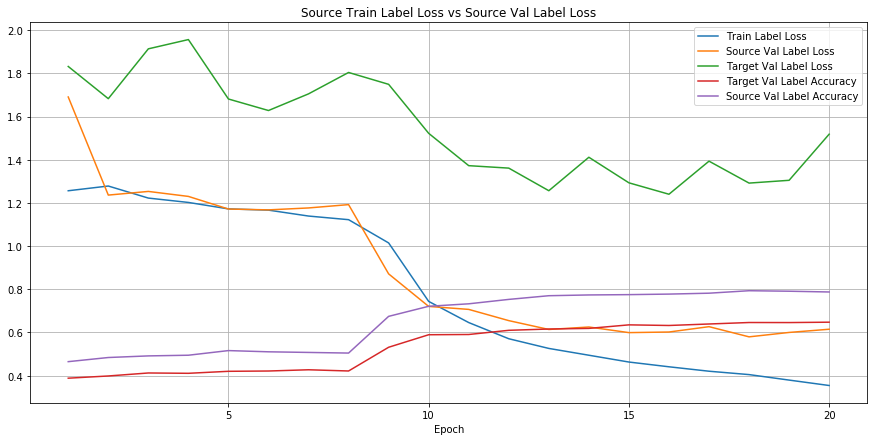

In [16]:
ax = get_loss_curve(experiment)
plt.show()

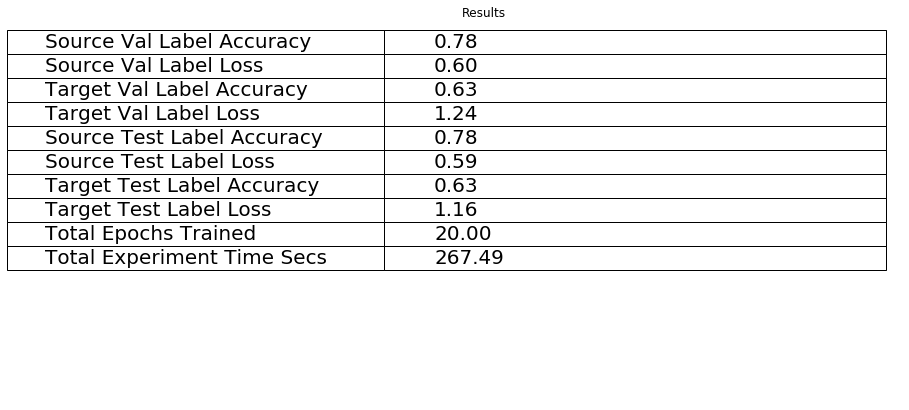

In [17]:
get_results_table(experiment)

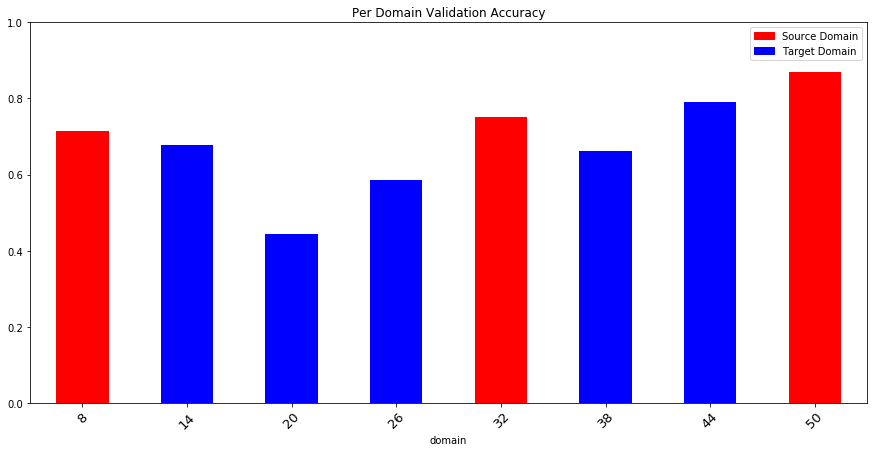

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.783125 Target Test Label Accuracy: 0.6315
Source Val Label Accuracy: 0.7775 Target Val Label Accuracy: 0.632125


In [20]:
json.dumps(experiment)

'{"experiment_name": "nShot_oracle.run2", "parameters": {"experiment_name": "nShot_oracle.run2", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "x_transforms_source": [], "x_transforms_target": [], "episode_transforms_source": [], "episode_transforms_target": [], "num_examples_per_domain_per_label_source": 1000, "num_examples_per_domain_per_label_target": 1000, "n_way": 16, "n_query": 2, "train_k_factor": 1, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", 